<a href="https://colab.research.google.com/github/paolobalasso/YoutubeTrading/blob/main/HedgedvsUnheadged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install yfinance
!pip install prophet

%matplotlib inline

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from prophet import Prophet



/tmp/ipython-input-4267946544.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  exchange_df = yf.download(['EURUSD=X','GBPUSD=X','EURGBP=X'],'2004-01-04',end = '2026-01-01')['Close']
[*********************100%***********************]  3 of 3 completed
/tmp/ipython-input-4267946544.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (exchange_df.pct_change()+1).cumprod().plot()


<Axes: xlabel='Date'>

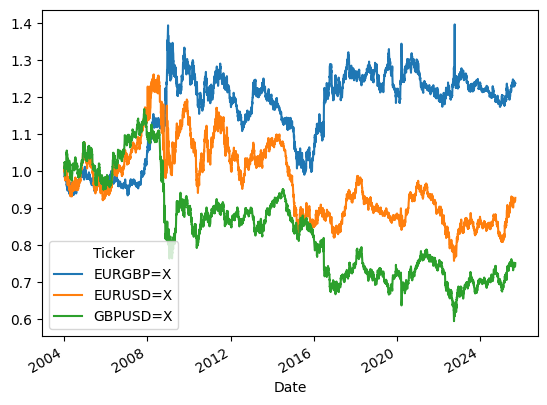

In [3]:
#EXCHANGE RATE

exchange_df = yf.download(['EURUSD=X','GBPUSD=X','EURGBP=X'],'2004-01-04',end = '2026-01-01')['Close']
(exchange_df.pct_change()+1).cumprod().plot()

In [13]:
yf.download(['EURUSD=X'],'2022-10-04',end = '2024-01-01',auto_adjust = False)['Close']

[*********************100%***********************]  1 of 1 completed


Ticker,EURUSD=X
Date,
2022-10-04,0.983207
2022-10-05,0.998432
2022-10-06,0.991100
2022-10-07,0.978905
2022-10-10,0.973501
...,...
2023-12-25,1.102657
2023-12-26,1.102026
2023-12-27,1.104301


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2546066322.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (prices['IWDA.AS'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01',auto_adjust = False)['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))


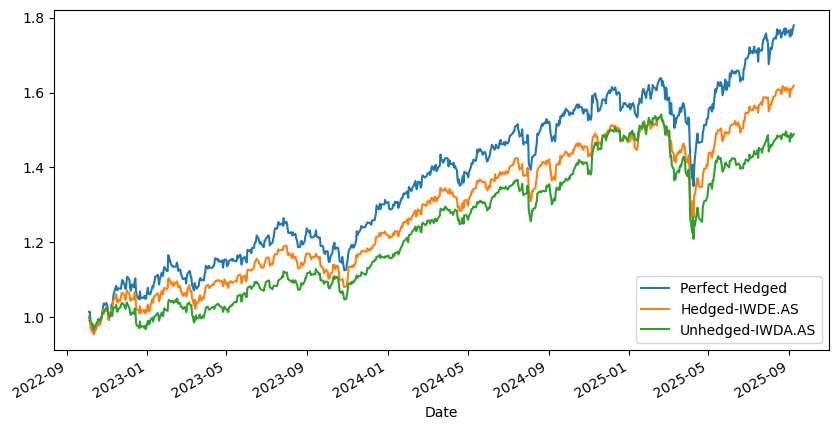

/tmp/ipython-input-2546066322.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  (yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close'].pct_change()+1).cumprod().plot(figsize=(10,5))
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

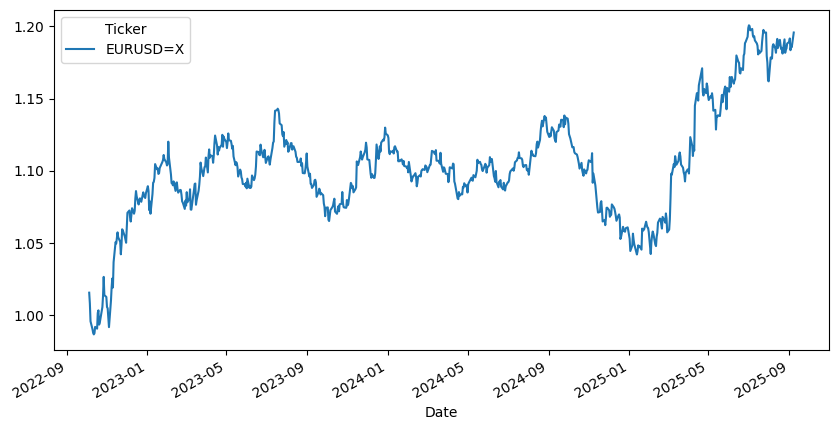

In [16]:
#MSCI WORLD

%matplotlib inline
prices = yf.download(['IWDE.AS','IWDA.AS'],"2022-10-04",end = '2026-01-01',auto_adjust = False)['Adj Close']
(prices['IWDA.AS'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01',auto_adjust = False)['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))
(prices['IWDE.AS'].pct_change()+1).cumprod().plot(label ='Hedged-IWDE.AS')
(prices['IWDA.AS'].pct_change()+1).cumprod().plot(label ='Unhedged-IWDA.AS')
plt.legend( loc ="lower right")
plt.show()
(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close'].pct_change()+1).cumprod().plot(figsize=(10,5))


In [18]:
%matplotlib inline
prices = yf.download(['IWDE.AS','IWDA.AS'],"2022-10-04",end = '2026-01-01',auto_adjust = False)['Adj Close']
prices['IWDA.PerfectHedged'] = prices['IWDA.AS'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index")

(prices.pct_change()+1).cumprod()

[*********************100%***********************]  2 of 2 completed
/tmp/ipython-input-2723480272.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices['IWDA.PerfectHedged'] = prices['IWDA.AS'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index")
[*********************100%***********************]  1 of 1 completed


Ticker,IWDA.AS,IWDE.AS,IWDA.PerfectHedged
Date,,,
2022-10-04,NaN,NaN,NaN
2022-10-05,0.998088,0.989592,1.013544
2022-10-06,1.005949,0.995630,1.014025
2022-10-07,0.986261,0.971876,0.981945
2022-10-10,0.982082,0.959323,0.972388
...,...,...,...
2025-09-02,1.468697,1.588623,1.750102
2025-09-03,1.478399,1.601096,1.749652
2025-09-04,1.491076,1.609915,1.768358


[*********************100%***********************]  2 of 2 completed
/tmp/ipython-input-1198772428.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  (prices['IDTL.L'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1198772428.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (prices['IDTL.L'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))


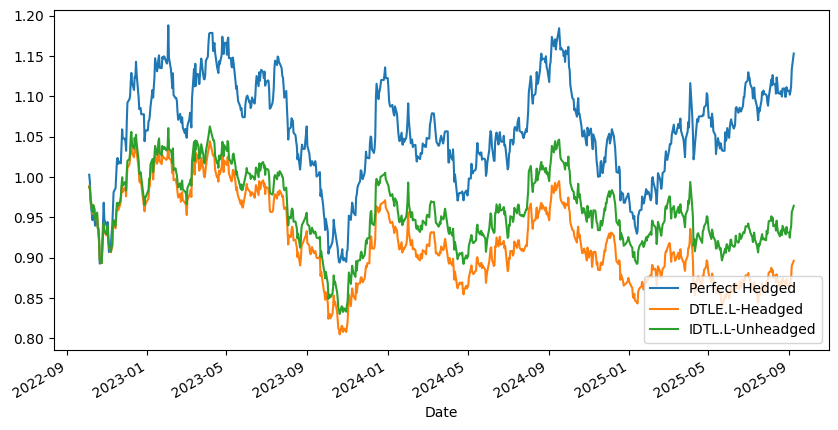

/tmp/ipython-input-1198772428.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  (yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close'].pct_change()+1).cumprod().plot(figsize=(10,5))
[*********************100%***********************]  1 of 1 completed


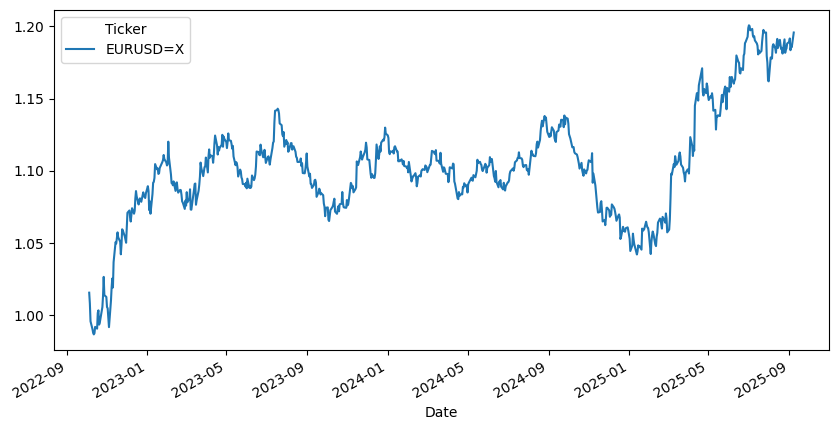

/tmp/ipython-input-1198772428.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices['IDTL.PerfectHedged'] = prices['IDTL.L'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index")
[*********************100%***********************]  1 of 1 completed


Ticker,DTLE.L,IDTL.L,IDTL.PerfectHedged
Date,,,
2022-10-04,NaN,NaN,NaN
2022-10-05,0.989019,0.987723,1.003018
2022-10-06,0.984572,0.986689,0.994610
2022-10-07,0.974534,0.974283,0.970019
2022-10-10,0.954524,0.956190,0.946751
...,...,...,...
2025-09-02,0.861224,0.924973,1.102200
2025-09-03,0.871211,0.934713,1.106211
2025-09-04,0.874313,0.938347,1.112843


In [19]:
#BOND ETFS
%matplotlib inline
prices = yf.download(['DTLE.L','IDTL.L'],"2022-10-04",end = '2026-01-01',auto_adjust = False)['Adj Close']
(prices['IDTL.L'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))
(prices['DTLE.L'].pct_change()+1).cumprod().plot(label ='DTLE.L-Headged')
(prices['IDTL.L'].pct_change()+1).cumprod().plot(label ='IDTL.L-Unheadged')
plt.legend( loc ="lower right")
plt.show()
(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close'].pct_change()+1).cumprod().plot(figsize=(10,5))
plt.show()

prices['IDTL.PerfectHedged'] = prices['IDTL.L'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index")
(prices.pct_change()+1).cumprod()**(1)


[*********************100%***********************]  2 of 2 completed
/tmp/ipython-input-1564592972.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  (prices['IS04.DE'].multiply(yf.download(['EURUSD=X'],'2019-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1564592972.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (prices['IS04.DE'].multiply(yf.download(['EURUSD=X'],'2019-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))
/tmp/ipython-input-1564592972.py:5: FutureWarning: The default fill_method='pad' 

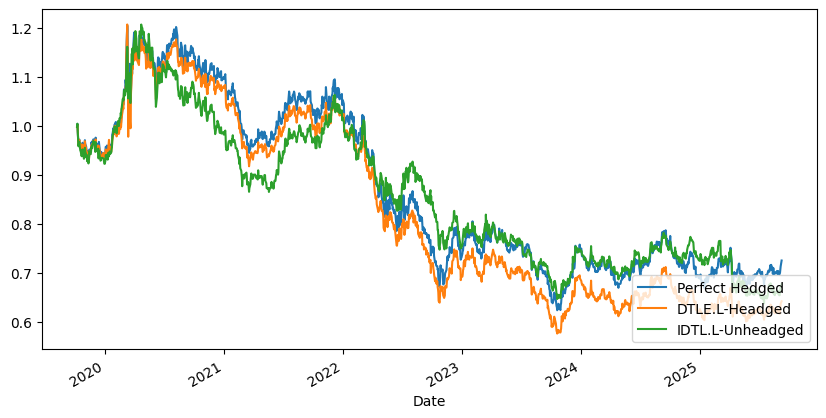

/tmp/ipython-input-1564592972.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  (yf.download(['EURUSD=X'],'2019-10-04',end = '2024-01-01')['Close'].pct_change()+1).cumprod().plot(figsize=(10,5))
[*********************100%***********************]  1 of 1 completed


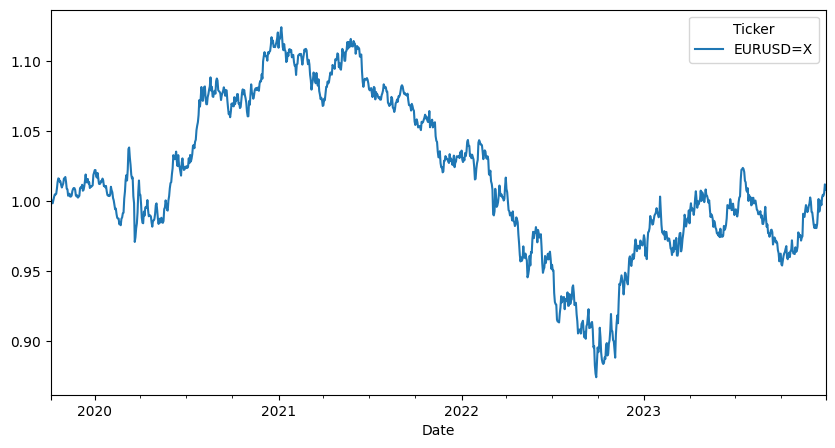

/tmp/ipython-input-1564592972.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices['IDTL.PerfectHedged'] = prices['IS04.DE'].multiply(yf.download(['EURUSD=X'],'2019-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1564592972.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (prices.pct_change()+1).cumprod()**(1/4)


Ticker,DTLE.L,IS04.DE,IDTL.PerfectHedged
Date,,,
2019-10-04,NaN,NaN,NaN
2019-10-07,0.999455,0.999372,0.999627
2019-10-08,1.000295,1.000927,1.000853
2019-10-09,0.997929,0.997684,0.997337
2019-10-10,0.994118,0.993279,0.993560
...,...,...,...
2025-09-02,0.885784,0.899236,0.914035
2025-09-03,0.888341,0.901198,0.914464
2025-09-04,0.889130,0.902537,0.916303


In [21]:
#BOND ETFS
%matplotlib inline
prices = yf.download(['DTLE.L','IS04.DE'],"2019-10-04",end = '2026-01-01',auto_adjust = False)['Adj Close']
(prices['IS04.DE'].multiply(yf.download(['EURUSD=X'],'2019-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))
(prices['DTLE.L'].pct_change()+1).cumprod().plot(label ='DTLE.L-Headged')
(prices['IS04.DE'].pct_change()+1).cumprod().plot(label ='IDTL.L-Unheadged')
plt.legend( loc ="lower right")
plt.show()
(yf.download(['EURUSD=X'],'2019-10-04',end = '2024-01-01')['Close'].pct_change()+1).cumprod().plot(figsize=(10,5))
plt.show()

prices['IDTL.PerfectHedged'] = prices['IS04.DE'].multiply(yf.download(['EURUSD=X'],'2019-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index")
(prices.pct_change()+1).cumprod()**(1/4)


[*********************100%***********************]  2 of 2 completed
/tmp/ipython-input-4207706289.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  (prices['IUSA.AS'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4207706289.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (prices['IUSA.AS'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))


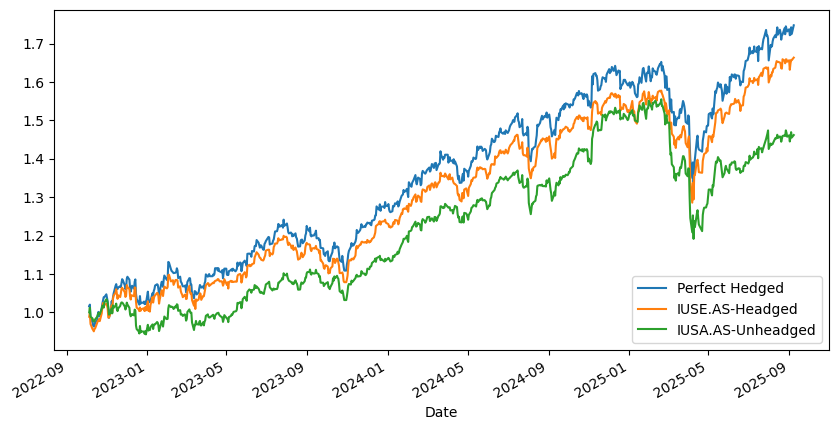

/tmp/ipython-input-4207706289.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  (yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close'].pct_change()+1).cumprod().plot()
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

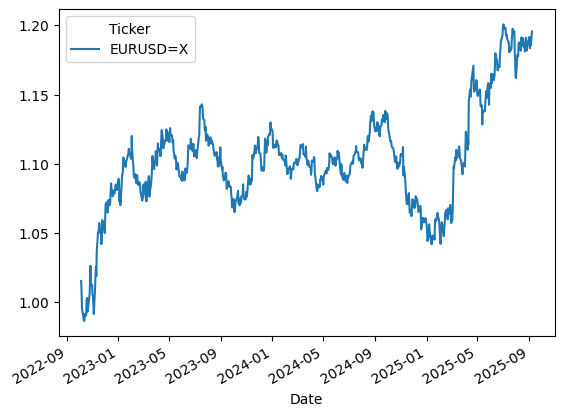

In [22]:
#MSCI US
%matplotlib inline
prices = yf.download(['IUSA.AS','IUES.AS'],"2022-10-04",end = '2026-01-01',auto_adjust = False)['Adj Close']
(prices['IUSA.AS'].multiply(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close']['EURUSD=X'],axis="index").pct_change()+1).cumprod().plot(label ='Perfect Hedged',figsize=(10,5))
(prices['IUES.AS'].pct_change()+1).cumprod().plot(label ='IUSE.AS-Headged',figsize=(10,5))
(prices['IUSA.AS'].pct_change()+1).cumprod().plot(label ='IUSA.AS-Unheadged',figsize=(10,5))
plt.legend( loc ="lower right")
plt.show()
(yf.download(['EURUSD=X'],'2022-10-04',end = '2026-01-01')['Close'].pct_change()+1).cumprod().plot()



In [24]:
%matplotlib inline
prices = yf.download(['IUSA.AS','IUES.AS'],"2022-10-04",end = '2024-01-01',auto_adjust = False)['Adj Close']
prices['IUSA.PerfectHedged'] = prices['IUSA.AS'].multiply(yf.download(['EURUSD=X'],'2019-10-04',end = '2024-01-01')['Close']['EURUSD=X'],axis="index")

(prices.pct_change()+1).cumprod()

[*********************100%***********************]  2 of 2 completed
/tmp/ipython-input-967979303.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices['IUSA.PerfectHedged'] = prices['IUSA.AS'].multiply(yf.download(['EURUSD=X'],'2019-10-04',end = '2024-01-01')['Close']['EURUSD=X'],axis="index")
[*********************100%***********************]  1 of 1 completed


Ticker,IUES.AS,IUSA.AS,IUSA.PerfectHedged
Date,,,
2022-10-04,NaN,NaN,NaN
2022-10-05,0.988406,1.000000,1.015486
2022-10-06,0.997366,1.011948,1.020072
2022-10-07,0.969636,0.988476,0.984150
2022-10-10,0.956491,0.984184,0.974469
...,...,...,...
2023-12-21,1.228365,1.135856,1.264509
2023-12-22,1.235492,1.139300,1.275351
2023-12-27,1.237892,1.132332,1.271793


In [25]:
#### Prediction

"""
Functions to evaluate the model
"""
def MAPE(y, y_hat):
        return np.mean(np.abs((y - y_hat)/y)) * 100

def RMSE(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

"""
Function to perform a univariate forecast and evaluate performance
"""
def uni_forecast(slug_df_lst, slug='EURUSD=X', plot=False, plot_comp=False):
    print('='*40)
    new = exchange_df_w['EURUSD=X'].reset_index()[['Date', 'EURUSD=X']]
    new = new.rename(columns={'Date': 'ds', 'EURUSD=X': 'y'})

    test_data = new.loc[(len(new)-52):len(new)]
    train_data = new.drop(test_data.index)
    print(f'Training data shape: {train_data.shape}')
    print(f'Test data shape: {test_data.shape}')

    model = Prophet(seasonality_mode='multiplicative')
    model.fit(train_data)

    future = test_data[['ds']]
    forecast = model.predict(future)
    print(f'Forecast data shape: {forecast.shape}')

    if plot == True:
          model.plot(forecast)
          exchange_df_w['EURUSD=X'].iloc[(len(new)-52):len(new)].plot(label='Test',color='black')
          plt.show()
    if plot_comp == True:
          model.plot_components(forecast)
          plt.show()

    mape = str(round(MAPE(test_data['y'].values, forecast['yhat'].values),2)) + "%"
    rmse = round(RMSE(test_data['y'].values, forecast['yhat'].values), 5)
    print(f'MAPE: {mape}')
    print(f'RMSE: {rmse}')


Training data shape: (1080, 2)
Test data shape: (52, 2)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbbtwstqr/41_pj730.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbbtwstqr/xfpp7hlk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59961', 'data', 'file=/tmp/tmpbbtwstqr/41_pj730.json', 'init=/tmp/tmpbbtwstqr/xfpp7hlk.json', 'output', 'file=/tmp/tmpbbtwstqr/prophet_modelsftw2a39/prophet_model-20250908133940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:39:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:39:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/

Forecast data shape: (52, 16)


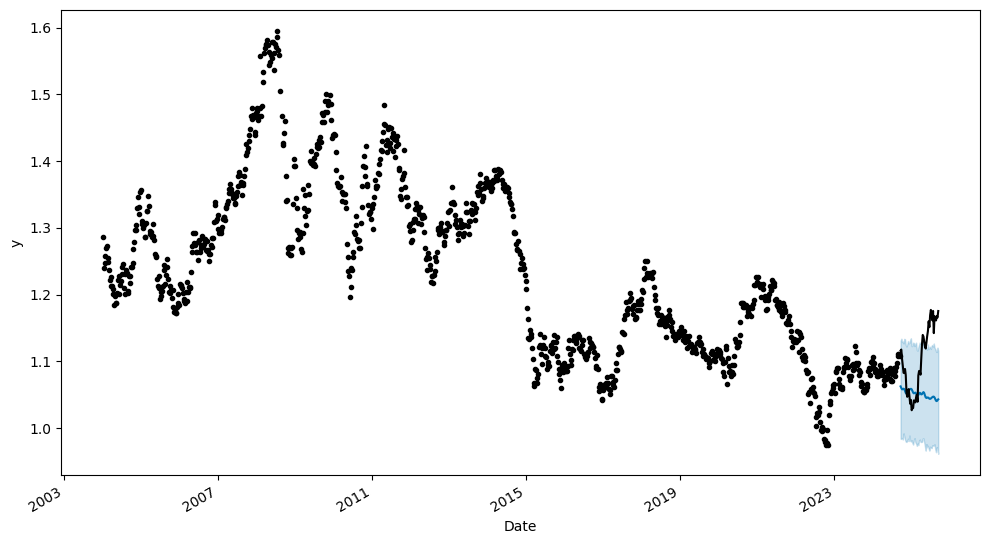

MAPE: 5.25%
RMSE: 0.07475


In [26]:
exchange_df_w = exchange_df.resample("W-FRI").last()
uni_forecast(exchange_df_w, slug='EURUSD=X', plot=True, plot_comp=False)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbbtwstqr/9cmmp7f6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbbtwstqr/vsy27iko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35231', 'data', 'file=/tmp/tmpbbtwstqr/9cmmp7f6.json', 'init=/tmp/tmpbbtwstqr/vsy27iko.json', 'output', 'file=/tmp/tmpbbtwstqr/prophet_modelzbtveey8/prophet_model-20250908134029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:40:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


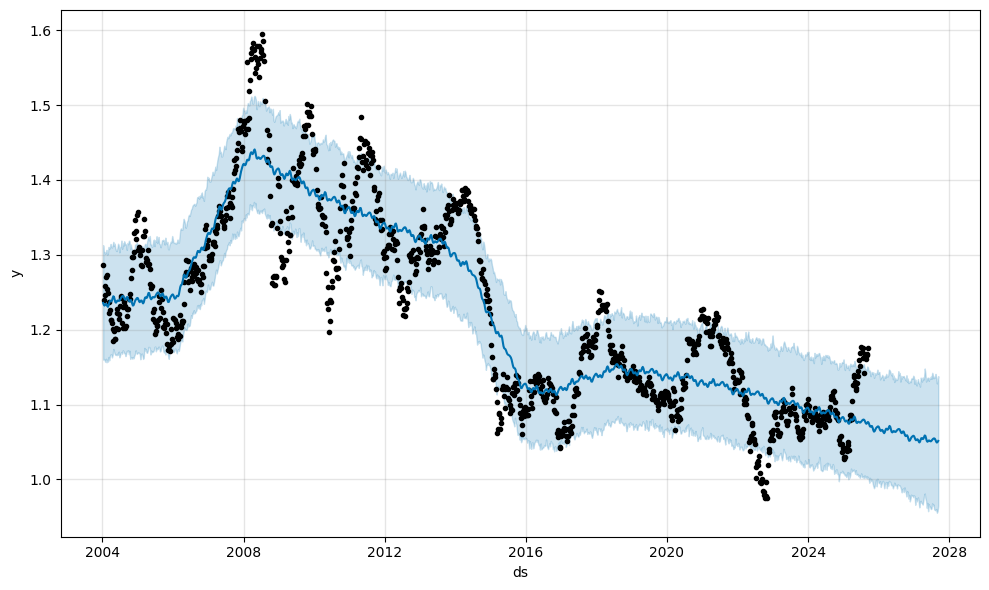

In [27]:
exchange_df_w = exchange_df.resample("W-FRI").last()
new = exchange_df_w['EURUSD=X'].reset_index()[['Date', 'EURUSD=X']]
new = new.rename(columns={'Date': 'ds', 'EURUSD=X': 'y'})
m = Prophet(seasonality_mode='multiplicative',yearly_seasonality=True).fit(new)
future = m.make_future_dataframe(periods=104,freq="W-FRI")
fcst = m.predict(future)
fig = m.plot(fcst)
